In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize, sent_tokenize
import numpy as np
import pandas as pd
import random
import math
import re
import nltk
nltk.download('punkt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Train, Val, Test split

In [2]:
corpus_path = '/kaggle/input/auguste-maquet/Auguste_Maquet.txt'

# Load the entire corpus
with open(corpus_path, "r") as f:
    corpus = f.read()

def clean(data):
    data = data.lower()
    data = re.sub(r'\n|\s+', ' ', data)  # replace newline and multiple spaces with single space
    data = re.sub(r"[^a-zA-Z0-9\s,.!?;:]", "", data) 
    data = re.sub(r'[’‘]', '\'', data)  # apostrophes
    data = re.sub(r'[“”`\' ]|[–—-]', ' ', data)  # quotes and dashes
    data = data.strip()
    return data

new_corpus = clean(corpus)
sentences = sent_tokenize(new_corpus)
print(len(sentences))

# Calculate the adjusted split sizes
train_size = int(0.7 * len(sentences))
val_size = int(0.2 * len(sentences))
test_size = int(0.1 * len(sentences))

# Split into train, validation, and test sets
train_sentences = sentences[:train_size]
validation_sentences = sentences[train_size:train_size + val_size]
test_sentences = sentences[train_size + val_size:train_size + val_size + test_size]

print(len(train_sentences), len(validation_sentences), len(test_sentences))

train_sentences = [word_tokenize(sentence.lower()) for sentence in train_sentences]
validation_sentences = [word_tokenize(sentence.lower()) for sentence in validation_sentences]
test_sentences = [word_tokenize(sentence.lower()) for sentence in test_sentences]

print(f"Number of tokenized train sentences: {len(train_sentences)}")
print(f"Number of tokenized validation sentences: {len(validation_sentences)}")
print(f"Number of tokenized test sentences: {len(test_sentences)}")

59326
41528 11865 5932
Number of tokenized train sentences: 41528
Number of tokenized validation sentences: 11865
Number of tokenized test sentences: 5932


In [3]:
train_sentences[1895]

['dartagnan',
 'turned',
 'around',
 'and',
 'plainly',
 'saw',
 'two',
 'human',
 'forms',
 'on',
 'planchets',
 'horse',
 '.']

## Building Vocab

In [4]:
from collections import Counter

def build_vocab(sentences):
    all_words = [word for sentence in sentences for word in sentence]
    word_counts = Counter(all_words)
    vocab = set(word_counts.keys())
    return vocab

all_sentences = train_sentences
vocab = build_vocab(all_sentences)

special_tokens = ['<UNK>']
for token in special_tokens:
    vocab.add(token)

vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 22265


## Glove embeddings

In [5]:
embedding_dim = 300

def load_glove_embeddings(glove_path):
    word_embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector

    special_tokens = ['<UNK>']
    for token in special_tokens:
        if token in ['<LINK>', '<NUM>']:
           # Random initialization for special tokens
          word_embeddings[token] = np.random.rand(embedding_dim).astype('float32')
        elif token == '<UNK>':
          # Mean of all embeddings in GloVe for <UNK>
          all_vectors = np.array(list(word_embeddings.values()))
          mean_vector = np.mean(all_vectors, axis=0)
          word_embeddings[token] = mean_vector
    
    return word_embeddings

glove_path = '/kaggle/input/glove-300/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

embedding_dim = len(glove_embeddings[next(iter(glove_embeddings))])
print(f"Loaded GloVe embeddings with dimension: {embedding_dim}")

Loaded GloVe embeddings with dimension: 300


## Mapping via word2index, index2word

In [6]:
def build_mappings(vocab, glove_embeddings):
    word2index = {word: idx for idx, word in enumerate(vocab)}
    index2word = {idx: word for word, idx in word2index.items()}

    return word2index, index2word

word2index, index2word = build_mappings(vocab, glove_embeddings)

print(f"Sample word2index mapping: {list(word2index.items())[:10]}")
print(f"Sample index2word mapping: {list(index2word.items())[:10]}")

count = 0
for word in word2index.keys():
    if word not in glove_embeddings:
        count = count + 1
        # print(f"Warning: GloVe embedding missing for {word}")

Sample word2index mapping: [('jackal', 0), ('tying', 1), ('twoandtwenty', 2), ('plundered', 3), ('dorleans', 4), ('publicly', 5), ('fewer', 6), ('valise', 7), ('wherein', 8), ('momenti', 9)]
Sample index2word mapping: [(0, 'jackal'), (1, 'tying'), (2, 'twoandtwenty'), (3, 'plundered'), (4, 'dorleans'), (5, 'publicly'), (6, 'fewer'), (7, 'valise'), (8, 'wherein'), (9, 'momenti')]


In [7]:
print(f"Size of glove embeddings: {len(glove_embeddings)}")

Size of glove embeddings: 400003


## N-gram generation

In [8]:
def generate_ngrams(sentences, n=5):
    contexts = []
    labels = []
    
    for sentence in sentences:
        if len(sentence) < n + 1:
            continue
            
        for i in range(len(sentence) - n):
            context = sentence[i:i+n]
            label = sentence[i+n]

            contexts.append(context)
            labels.append(label)

    return contexts, labels

train_ngrams, train_labels = generate_ngrams(train_sentences)
validation_ngrams, val_labels = generate_ngrams(validation_sentences)
test_ngrams, test_labels = generate_ngrams(test_sentences)

In [9]:
len(train_ngrams), len(validation_ngrams), len(test_ngrams)

(588010, 158983, 76346)

In [10]:
for i in range(5):
  print(train_ngrams[i])

['the', 'project', 'gutenberg', 'ebook', 'of']
['project', 'gutenberg', 'ebook', 'of', 'twenty']
['gutenberg', 'ebook', 'of', 'twenty', 'years']
['ebook', 'of', 'twenty', 'years', 'after']
['of', 'twenty', 'years', 'after', 'this']


## Dataset

In [12]:
class NgramDataset(Dataset):
    def __init__(self, ngrams, labels, word_to_index, word_to_embedding, embedding_dim):
        self.ngrams = ngrams
        self.labels = labels
        self.word_to_index = word_to_index
        self.word_to_embedding = word_to_embedding
        self.embedding_dim = embedding_dim

        # Define a zero vector for out of vocab words
        self.zero_vector = torch.zeros(embedding_dim, dtype=torch.float32)

    def __len__(self):
        return len(self.ngrams)

    def __getitem__(self, idx):
        ngram = self.ngrams[idx]
        label = self.labels[idx]

        # Convert n-gram to embeddings with OOV handling and word-to-index check
        ngram_embeddings = torch.cat([
            torch.tensor(
                # If the word exists in vocab (word_to_index), use the word's embedding
                self.word_to_embedding.get(word if word in self.word_to_index else '<UNK>', self.zero_vector),
                dtype=torch.float32
            ).unsqueeze(0)
            for word in ngram
        ], dim=0)

        ngram_embeddings_flat = ngram_embeddings.view(-1)

        # Convert label to index and create a tensor
        label_index = self.word_to_index.get(label, self.word_to_index.get('<UNK>'))
        label_tensor = torch.tensor(label_index, dtype=torch.long)

        return ngram_embeddings_flat, label_tensor

embedding_dim = 300
glove_embeddings = load_glove_embeddings(glove_path)

train_dataset = NgramDataset(train_ngrams, train_labels, word2index, glove_embeddings, embedding_dim)
validation_dataset = NgramDataset(validation_ngrams, val_labels, word2index, glove_embeddings, embedding_dim)
test_dataset = NgramDataset(test_ngrams, test_labels, word2index, glove_embeddings, embedding_dim)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Ngram class

In [13]:
class NGramLanguageModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, dropout):
        super(NGramLanguageModel, self).__init__()
        self.hidden_dim = hidden_dim

        # Define the layers
        self.hidden1 = nn.Linear(embedding_dim * 5, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout1 = nn.Dropout(dropout)
        self.to(device)

    def forward(self, x):
        # Assuming x is (batch_size, 1500)
        x = torch.relu(self.hidden1(x))
        x = self.dropout1(x)
        x = torch.relu(self.hidden2(x))
        # x = self.dropout2(x)
        x = self.fc(x)
        return x

embedding_dim = 300
hidden_dim = 300
dropout = 0.3
model = NGramLanguageModel(embedding_dim, hidden_dim, vocab_size, dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=0, factor=0.1)

## Train model

In [25]:
import torch
import math

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience = 3):
    best_val_loss = float('inf')
    patience_counter = 0

    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0  
        batch_no = 1
        for batch in train_loader:
            inputs = batch[0].to(device)
            targets = batch[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        average_train_loss = total_train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_train_loss:.4f}')

        # Validation phase
        with torch.no_grad():
            model.eval()
            total_val_loss = 0
            for batch in val_loader:
                inputs = batch[0].to(device)
                targets = batch[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
                
        average_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}')
        scheduler.step(average_val_loss)
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'N-gram_model.pth') 
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

## Evaluate model

In [31]:
def evaluate_model(model, data_loader, device, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in data_loader:
            inputs = batch[0].to(device)
            targets = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    average_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(average_loss))
    return average_loss, perplexity.item()

In [28]:
train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs = 10, patience = 3)

/tmp/ipykernel_37/2565038894.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


Epoch [1/10], Training Loss: 5.2071
Epoch [1/10], Validation Loss: 5.5973
Epoch [2/10], Training Loss: 4.9981
Epoch [2/10], Validation Loss: 5.5812
Epoch [3/10], Training Loss: 4.9126
Epoch [3/10], Validation Loss: 5.6158
Epoch [4/10], Training Loss: 4.7481
Epoch [4/10], Validation Loss: 5.6004
Epoch [5/10], Training Loss: 4.6922
Epoch [5/10], Validation Loss: 5.6045
Early stopping triggered after 5 epochs.


In [32]:
train_loss, train_perplexity = evaluate_model(model, train_loader, device, criterion)
val_loss, val_perplexity = evaluate_model(model, validation_loader, device, criterion)
test_loss, test_perplexity = evaluate_model(model, test_loader, device, criterion)

/tmp/ipykernel_37/2565038894.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


Validation Loss: 5.6045, Validation Perplexity: 271.6375
Test Loss: 5.6166, Test Perplexity: 274.9510


In [33]:
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Perplexity: {train_perplexity:.4f}")

Train Loss: 4.6859
Train Perplexity: 108.4087


In [34]:
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Perplexity: {val_perplexity:.4f}")

Val Loss: 5.6045
Val Perplexity: 271.6375


In [35]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")

Test Loss: 5.6166
Test Perplexity: 274.9510


In [36]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
    
save_model(model,"2021101102-LM1-Ngram.pth")

Model saved to 2021101102-LM1-Ngram.pth


## Saving perplexities to file

In [46]:
def save_perplexities(model, data_loader, file_name):
    
    model.eval()  
    batch_perplexities = []
    total_loss = 0
    batch_idx = 0  
    
    with torch.no_grad():  
         for batch in data_loader:
            batch_idx += 1
            inputs = batch[0].to(device)
            targets = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
        
            batch_perplexity = math.exp(loss.item())
            batch_perplexities.append(batch_perplexity)

            # Write to file (append mode)
            with open(file_name, 'a') as f:
                f.write(f'Batch {batch_idx + 1}: {batch_perplexity:.4f}\n')

    # Compute the average test loss and perplexity
    avg_test_loss = total_loss / batch_idx
    avg_perplexity = math.exp(avg_test_loss)
    
    with open(file_name, 'a') as f:
        f.write(f'Average Perplexity: {avg_perplexity:.4f}\n')

    # Print average perplexity
    print(f'Average Perplexity: {avg_perplexity:.4f}')
    return avg_perplexity

In [48]:
train_path = "2021101102-LM1-train-perplexity.txt"
val_path = "2021101102-LM1-val-perplexity.txt"
test_path = "2021101102_LM1-test-perplexity.txt"

# Createa loaders with size 1
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

save_perplexities(model, train_loader, train_path)
save_perplexities(model, validation_loader, val_path)
save_perplexities(model, test_loader, test_path)

/tmp/ipykernel_37/2565038894.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


Average Perplexity: 108.4090
Average Perplexity: 271.6516
Average Perplexity: 274.9530


274.95301425925214

# Hyperparameter tuning

In [51]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [63]:
import torch.optim as optim

dropouts = [0.1, 0.2, 0.3]
hidden_dims = [100, 200, 300]
optimizers = ["Adam", "SGD"]

results = []

for dropout in dropouts:
    for hid_dim in hidden_dims:
        for optimi in optimizers:
           
            model = NGramLanguageModel(embedding_dim, hid_dim, vocab_size, dropout=dropout)
        
            if optimi == "Adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            else:
                optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.8)
            

            train_model(model, train_loader, validation_loader, criterion, optimizer, scheduler, num_epochs = 10, patience = 3)
            train_loss, train_perplexity = evaluate_model(model, train_loader, device, criterion)
            test_loss, test_perplexity = evaluate_model(model, test_loader, device, criterion)
            print(dropout, hid_dim, optimi, train_perplexity, test_perplexity)
            
            # Store the hyperparameters and their corresponding perplexities
            results.append({
                'dropout': dropout,
                'hidden_dim': hid_dim,
                'optimizer': optimi,
                'train_perplexity': train_perplexity,
                'test_perplexity': test_perplexity
            })

/tmp/ipykernel_37/2565038894.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


Epoch [1/10], Training Loss: 6.9483
Epoch [1/10], Validation Loss: 6.2851
Epoch [2/10], Training Loss: 6.1634
Epoch [2/10], Validation Loss: 6.0346
Epoch [3/10], Training Loss: 5.9711
Epoch [3/10], Validation Loss: 5.8912
Epoch [4/10], Training Loss: 5.8358
Epoch [4/10], Validation Loss: 5.7769
Epoch [5/10], Training Loss: 5.7259
Epoch [5/10], Validation Loss: 5.6865
Epoch [6/10], Training Loss: 5.6387
Epoch [6/10], Validation Loss: 5.6213
Epoch [7/10], Training Loss: 5.5681
Epoch [7/10], Validation Loss: 5.5654
Epoch [8/10], Training Loss: 5.5081
Epoch [8/10], Validation Loss: 5.5147
Epoch [9/10], Training Loss: 5.4554
Epoch [9/10], Validation Loss: 5.4783
Epoch [10/10], Training Loss: 5.4079
Epoch [10/10], Validation Loss: 5.4399
0.2 200 SGD 215.47567749023438 241.51815795898438
Epoch [1/10], Training Loss: 6.9141
Epoch [1/10], Validation Loss: 6.2289
Epoch [2/10], Training Loss: 6.1232
Epoch [2/10], Validation Loss: 5.9778
Epoch [3/10], Training Loss: 5.9399
Epoch [3/10], Validation

In [ ]:
import torch.optim as optim
import csv
output_file = '/kaggle/working/experiment_results.csv'

with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['dropout', 'hidden_dim', 'optimizer', 'train_perplexity', 'test_perplexity']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()  # Write the header row
    for result in results:
        writer.writerow(result)

## Plots

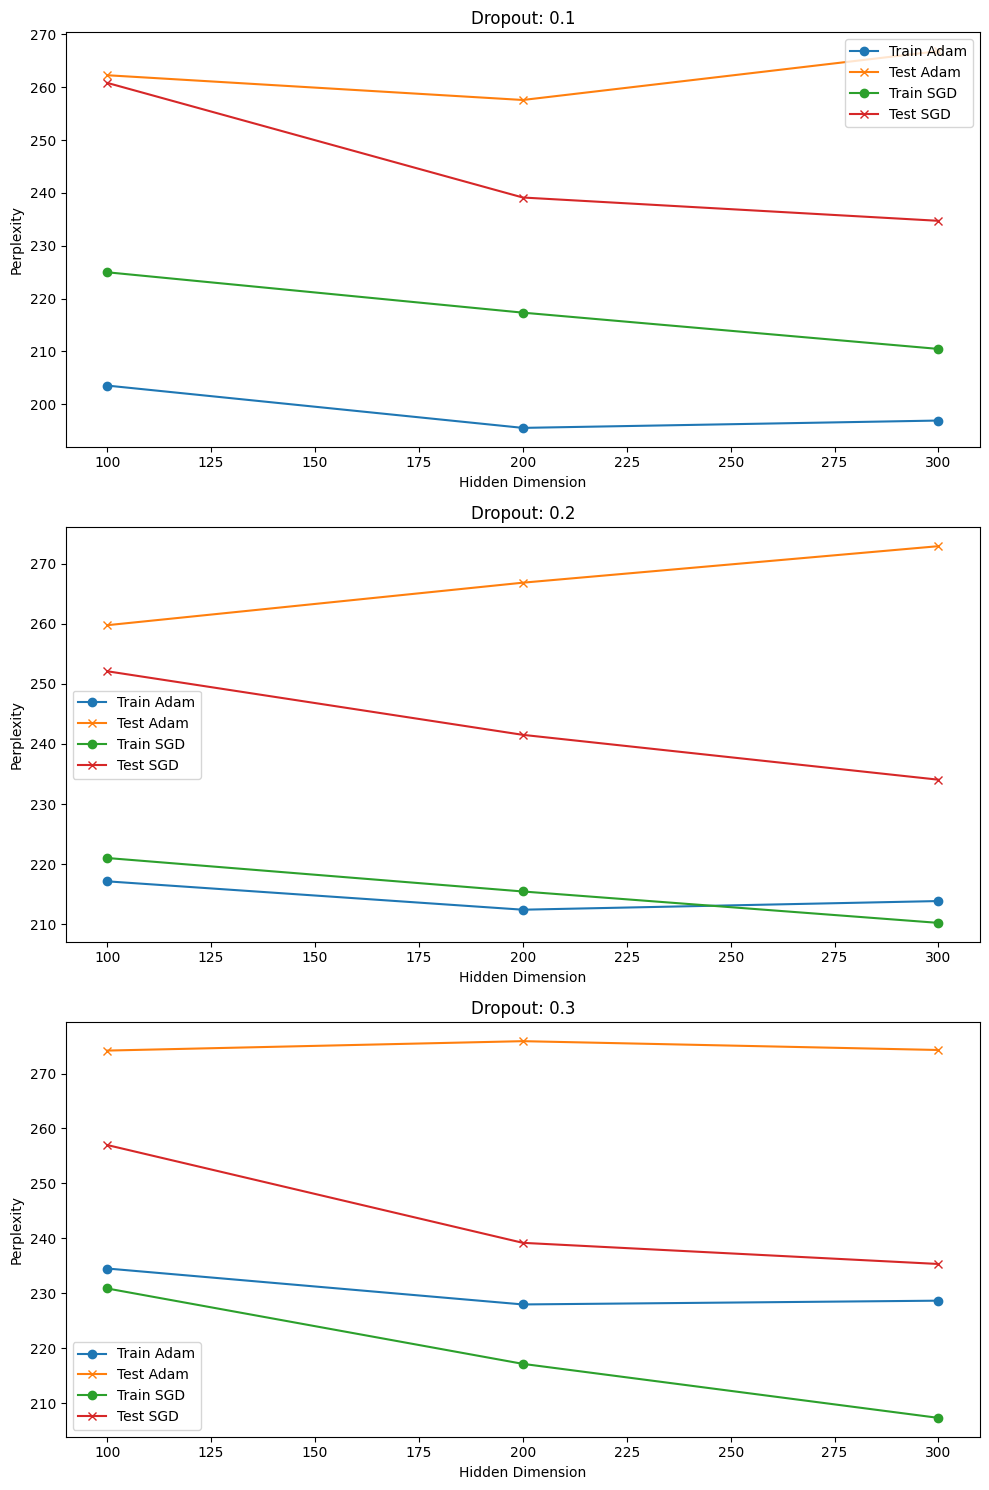

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Reading the CSV file into a DataFrame
file_path = '/kaggle/input/hyper-results2/experiment_results_final2.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Creating subplots for each dropout value
dropouts = df['dropout'].unique()
optimizers = df['optimizer'].unique()

# Create subplots based on the number of dropout values
fig, axs = plt.subplots(nrows=len(dropouts), ncols=1, figsize=(10, len(dropouts)*5))

# If there's only one subplot, axs will not be an array, so we convert it to a list for consistency
if len(dropouts) == 1:
    axs = [axs]

for i, dropout in enumerate(dropouts):
    ax = axs[i]
    for optimizer in optimizers:
        # Filter data for each dropout and optimizer
        data = df[(df['dropout'] == dropout) & (df['optimizer'] == optimizer)]
        
        # Plot train perplexity
        ax.plot(data['hidden_dim'], data['train_perplexity'], label=f'Train {optimizer}', marker='o')
        
        # Plot test perplexity
        ax.plot(data['hidden_dim'], data['test_perplexity'], label=f'Test {optimizer}', marker='x')
    
    # Titles and labels for each subplot
    ax.set_title(f'Dropout: {dropout}')
    ax.set_xlabel('Hidden Dimension')
    ax.set_ylabel('Perplexity')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('dropout_perplexity_plots.png', dpi=300) 
# Show the plot
plt.show()

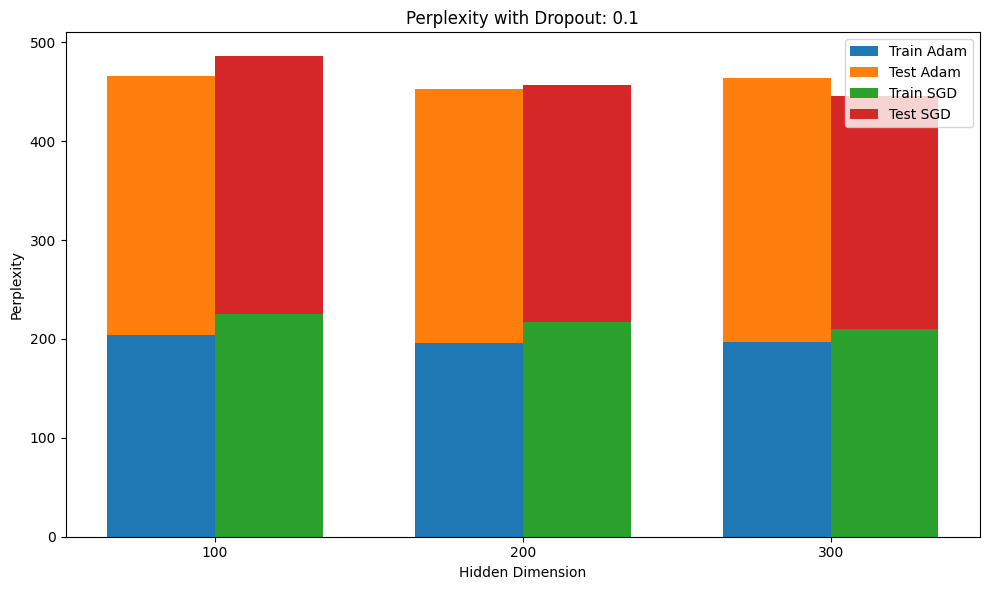

<Figure size 640x480 with 0 Axes>

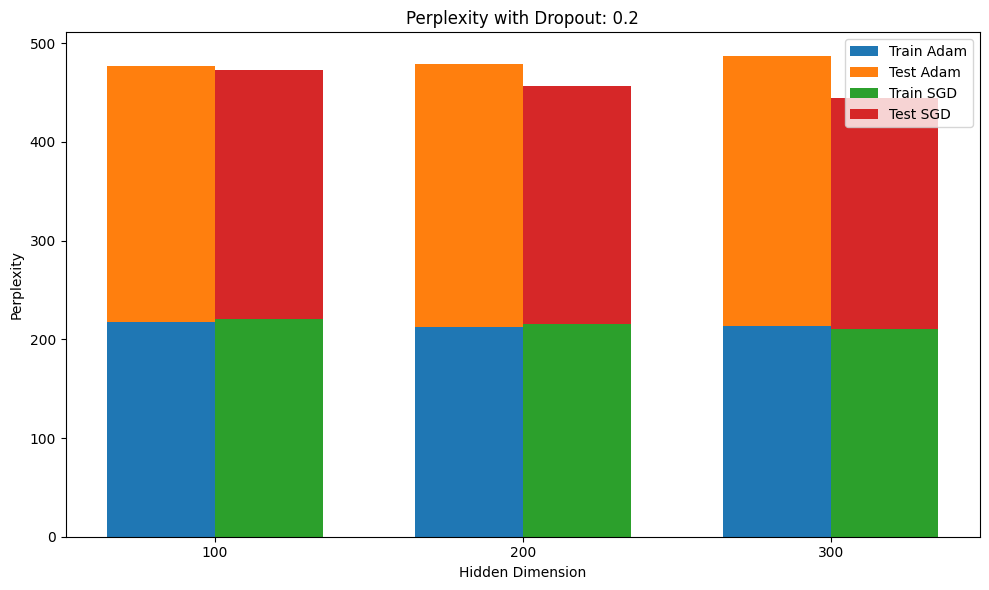

<Figure size 640x480 with 0 Axes>

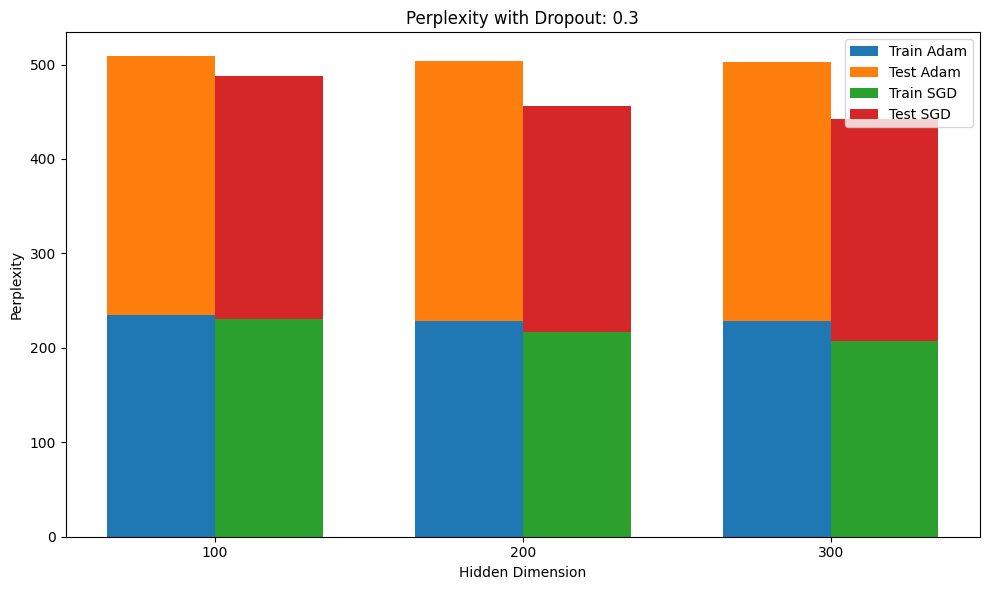

<Figure size 640x480 with 0 Axes>

In [68]:
file_path = '/kaggle/input/hyper-results2/experiment_results_final2.csv'  
df = pd.read_csv(file_path)

# Creating grouped bar plots for train and test perplexities
dropouts = df['dropout'].unique()
optimizers = df['optimizer'].unique()
hidden_dims = df['hidden_dim'].unique()

# Set width for bars
bar_width = 0.35
index = np.arange(len(hidden_dims))

for dropout in dropouts:
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, optimizer in enumerate(optimizers):
        # Filter data for each dropout and optimizer
        data = df[(df['dropout'] == dropout) & (df['optimizer'] == optimizer)]
        
        # Bar plot for train perplexity
        ax.bar(index + i * bar_width, data['train_perplexity'], bar_width, label=f'Train {optimizer}')
        
        # Bar plot for test perplexity (stacking bars on top of train perplexity)
        ax.bar(index + i * bar_width, data['test_perplexity'], bar_width, bottom=data['train_perplexity'], label=f'Test {optimizer}')

    # Titles and labels
    ax.set_title(f'Perplexity with Dropout: {dropout}')
    ax.set_xlabel('Hidden Dimension')
    ax.set_ylabel('Perplexity')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(hidden_dims)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    plt.savefig('/kaggle/working/perplexity_plot.png')  # Save the plot as PNG
plt.show()

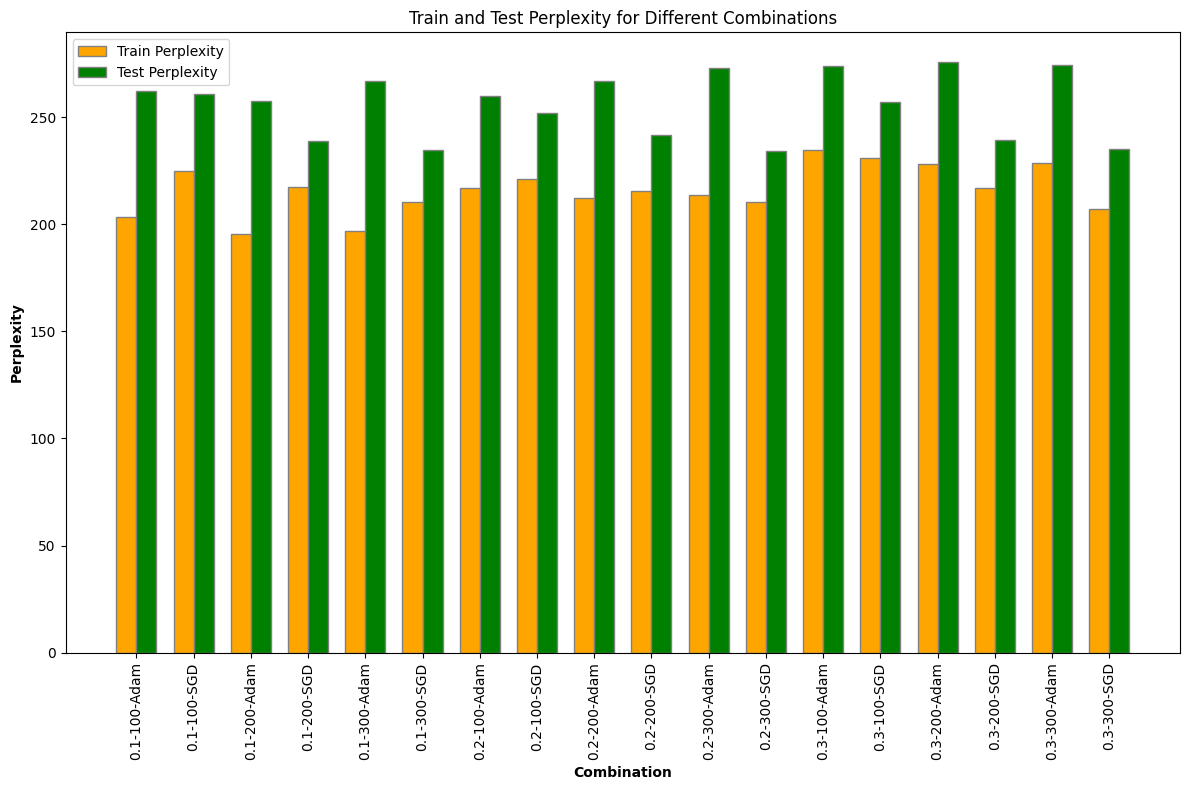

In [73]:
file_path = '/kaggle/input/hyper-results2/experiment_results_final2.csv'  
df = pd.read_csv(file_path)
df['Combination'] = df['dropout'].astype(str) + '-' + df['hidden_dim'].astype(str) + '-' + df['optimizer']

# Set the figure size
plt.figure(figsize=(12, 8))

# Define the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(df))
r2 = [x + bar_width for x in r1]

# Plot train perplexity
plt.bar(r1, df['train_perplexity'], color='orange', width=bar_width, edgecolor='grey', label='Train Perplexity')

# Plot test perplexity
plt.bar(r2, df['test_perplexity'], color='green', width=bar_width, edgecolor='grey', label='Test Perplexity')

# Add labels and title
plt.xlabel('Combination', fontweight='bold')
plt.ylabel('Perplexity', fontweight='bold')
plt.title('Train and Test Perplexity for Different Combinations')

# Add the x-ticks and labels
plt.xticks([r + bar_width/2 for r in range(len(df))], df['Combination'], rotation=90)

# Add legend
plt.legend()
plt.savefig('perplexity_comparison.png', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

In [74]:
best_train_idx = df['train_perplexity'].idxmin()

# Find the index of the minimum test perplexity
best_test_idx = df['test_perplexity'].idxmin()

# Get the best combination for train perplexity
best_train_combination = df.loc[best_train_idx, 'Combination']
best_train_value = df.loc[best_train_idx, 'train_perplexity']

# Get the best combination for test perplexity
best_test_combination = df.loc[best_test_idx, 'Combination']
best_test_value = df.loc[best_test_idx, 'test_perplexity']

print(f"Best combination for minimum train perplexity: {best_train_combination} with train perplexity = {best_train_value}")
print(f"Best combination for minimum test perplexity: {best_test_combination} with test perplexity = {best_test_value}")

Best combination for minimum train perplexity: 0.1-200-Adam with train perplexity = 195.547784
Best combination for minimum test perplexity: 0.2-300-SGD with test perplexity = 234.060974


In [ ]:
# def predict_next_words(model, sentence, word_to_index, word_to_embedding, index_to_word, top_k=5, temperature=0.7):
#     model.eval()

#     # Tokenize and preprocess the sentence
#     sentence_tokens = word_tokenize(sentence.lower())

#     # Select the last 5 tokens as the context (n-gram)
#     ngram = sentence_tokens[-5:] if len(sentence_tokens) >= 5 else sentence_tokens

#     # Convert the n-gram words to their embeddings with OOV handling
#     ngram_embeddings = torch.cat([
#         torch.tensor(
#             word_to_embedding.get(word if word in word_to_index else '<UNK>', torch.zeros(embedding_dim, dtype=torch.float32)),
#             dtype=torch.float32
#         ).unsqueeze(0) for word in ngram
#     ], dim=0)

#     ngram_embeddings_flat = ngram_embeddings.view(-1).unsqueeze(0).to(device)  # Add batch dimension and move to device

#     # Get the model's predictions
#     with torch.no_grad():
#         output = model(ngram_embeddings_flat)  # Output is (1, vocab_size)

#         # Apply temperature scaling before softmax
#         output = output / temperature
#         probabilities = F.softmax(output, dim=-1)  # Apply softmax to get probabilities

#     # Get the top-k predictions and their indices
#     top_k_probs, top_k_indices = torch.topk(probabilities, top_k, dim=-1)

#     # Convert indices to words
#     top_k_words = [index_to_word[idx.item()] for idx in top_k_indices[0]]

#     # Return the top k words and their probabilities
#     return list(zip(top_k_words, top_k_probs[0].cpu().numpy()))
